In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import random
from tqdm import tqdm
plt.style.use('dark_background')

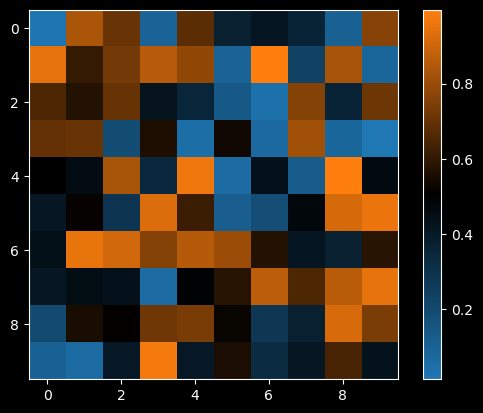

In [7]:
# Define a list of colors
colors = ['tab:blue', 'black', 'tab:orange']

# Create a custom colormap
data = np.random.rand(10, 10)
the_cmap = LinearSegmentedColormap.from_list("the_cmap", colors)

# Use the custom colormap
plt.imshow(data, cmap=the_cmap)
plt.colorbar()
plt.show()

In [35]:
def initial_spins(L):
    return np.random.choice([1, -1], size=(L, L, L))


def aligned_spins(L):
    return np.ones((L, L, L))


def calculate_energy(spins, K, h, L):
    energy = 0
    for i in range(L):
        for j in range(L):
            for k in range(L):
                energy -= h*spins[i, j, k]
                energy -= K*(spins[(i+1)%L, j, k] + spins[i, (j+1)%L, k] + spins[i, j, (k+1)%L])*spins[i, j, k]
    return energy


def calculate_M(spins, L):
    M = np.sum(spins)
    return M


def calculate_C(total_E, total_E_squared, mcs):
    # 1/T^2 (<E^2> - <E>^2)
    avg_E = total_E/mcs
    avg_E_squared = total_E_squared/mcs
    C = T**(-2)*(avg_E_squared - avg_E**2)
    return C/(L**3)


def calculate_sus(total_M, total_M_squared, mcs):
    # 1/T (<M^2> - <M>^2)
    avg_M = total_M/mcs
    avg_M_squared = total_M_squared/mcs
    sus = T**(-1)*(avg_M_squared - avg_M**2)
    return sus


def calculate_correlation_length(spins, M, mcs, L):
    # exp(-r/xi) = <s_i s_j> - m^2 --> -r/xi = ln(|<s_i s_j> - m^2|) ---> xi = -r/ln(|sus|)
    
    
    m = M/(L**3)
    m_squared = m**2

    xi_accumulator = 0
    counter = 0
    for i in range(L):
        for j in range(L):
            spin1 = spins[i, i, i]
            spin2 = spins[j, j, j]
            spin12 = spin1*spin2
            diff = np.abs(spin12 - m_squared)

            r = np.sqrt(3*(i-j)**2)
            xi = -r/np.log(diff)
            xi_accumulator += xi
            counter += 1

    return xi_accumulator/counter


    # m = M/(L**3)
    # m_squared = m**2

    # # xi_accumulator = 0
    # spin12_accum = 0
    # r_accum = 0
    # counter = 0
    # for i in range(L):
    #     for j in range(L):
    #         spin1 = spins[i, i, i]
    #         spin2 = spins[j, j, j]
    #         spin12 = spin1*spin2
    #         spin12_accum += spin12

    #         r_accum += np.sqrt(3*(i-j)**2)

    #         counter += 1

    # r = r_accum/counter
    # spin12 = spin12_accum/counter
    # diff = np.abs(spin12 - m_squared)
    # xi = -r/np.log(diff)
    # # xi_accumulator += xi





In [47]:
def metropolis_algorithim(spins, T, K, h, L):
    # compute beta
    beta = 1/T
    
    #making a trial flip
    i, j, k = np.random.randint(0, L, size=3)
    site = spins[i, j, k]
    trial_flip = site * -1
    trial_flip_spins = spins.copy()
    trial_flip_spins[i, j, k] = trial_flip

    #calculating old energy
    old_energy = -h*spins[i, j, k] - K*(spins[(i+1)%L, j, k] + spins[i, (j+1)%L, k] + spins[i, j, (k+1)%L] +
                                     spins[(i - 1) % L, j, k] +  spins[i, (j-1)%L, k] + spins[i, j, (k-1)%L])*spins[i, j, k]
    #calculating new energy
    new_energy = -h*trial_flip_spins[i, j, k]
    new_energy -= K*(trial_flip_spins[(i+1)%L, j, k] + trial_flip_spins[i, (j+1)%L, k] + trial_flip_spins[i, j, (k+1)%L] +
                                      trial_flip_spins[(i - 1) % L, j, k] +  trial_flip_spins[i, (j-1)%L, k]
                                       + trial_flip_spins[i, j, (k-1)%L])*trial_flip_spins[i, j, k]
    #computing delta E and deciding if we should accept the change
    delta_energy = new_energy - old_energy
    if delta_energy <= 0:
        spins[i, j, k] = trial_flip
    else:
        w = np.exp(-beta*delta_energy)
        r = random.random()
        if r <= w:
            spins[i, j, k] = trial_flip
    return(spins)

def monte_carlo(T, K, h, L, steps, spins):
    mcs = 0
    total_E = 0
    total_E_squared = 0
    total_M = 0
    total_M_squared = 0

    energies = []
    magnetizations = []
    specific_heats = []
    susceptibilities = []
    correlations = []

    for step in tqdm(range(steps)):
        spins = metropolis_algorithim(spins, T, K, h, L)
        if step % 100 == 0 or step == steps-1:
            mcs += 1
            energy = calculate_energy(spins, K, h, L)
            total_E += energy
            total_E_squared += energy**2

            mag = calculate_M(spins, L)
            total_M += np.abs(mag)
            total_M_squared += mag**2
            
            energies.append(energy)
            magnetizations.append(mag)
            specific_heats.append(calculate_C(total_E, total_E_squared, mcs))
            susceptibilities.append(calculate_sus(total_M, total_M_squared, mcs))
            correlations.append(calculate_correlation_length(spins, mag, mcs, L))

    return spins, (energies, magnetizations, specific_heats, susceptibilities, correlations)

In [37]:
def scatter_3D(data, ax, title):
    x = np.indices(data.shape)[0]
    y = np.indices(data.shape)[1]
    z = np.indices(data.shape)[2]
    col = data.flatten()
    
    # 3D Plot
    p3d = ax.scatter(x, y, z, c=col, cmap=the_cmap, vmin=-1, vmax=1)
    ax.grid(False)
    plt.colorbar(p3d, label="Spin")
    ax.set_title(title)

    # make the panes transparent
    ax.xaxis.set_pane_color('black')
    ax.yaxis.set_pane_color('black')
    ax.zaxis.set_pane_color('black')

    return

In [38]:
def normalize(array):
    normalized_array = array.copy()
    max = np.max(array)
    min = np.min(array)
    for i in range(len(array)):
        normalized_array[i] = (normalized_array[i] - min)/(max-min)
    return normalized_array

def difference(array):
    differences = array.copy()[:-1]
    for i in range(len(array)-1):
        differences[i] = array[i+1] - array[i]
    return differences

/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_1707/1831189862.py:57: RuntimeWarning: divide by zero encountered in log
  xi = -r/np.log(diff)


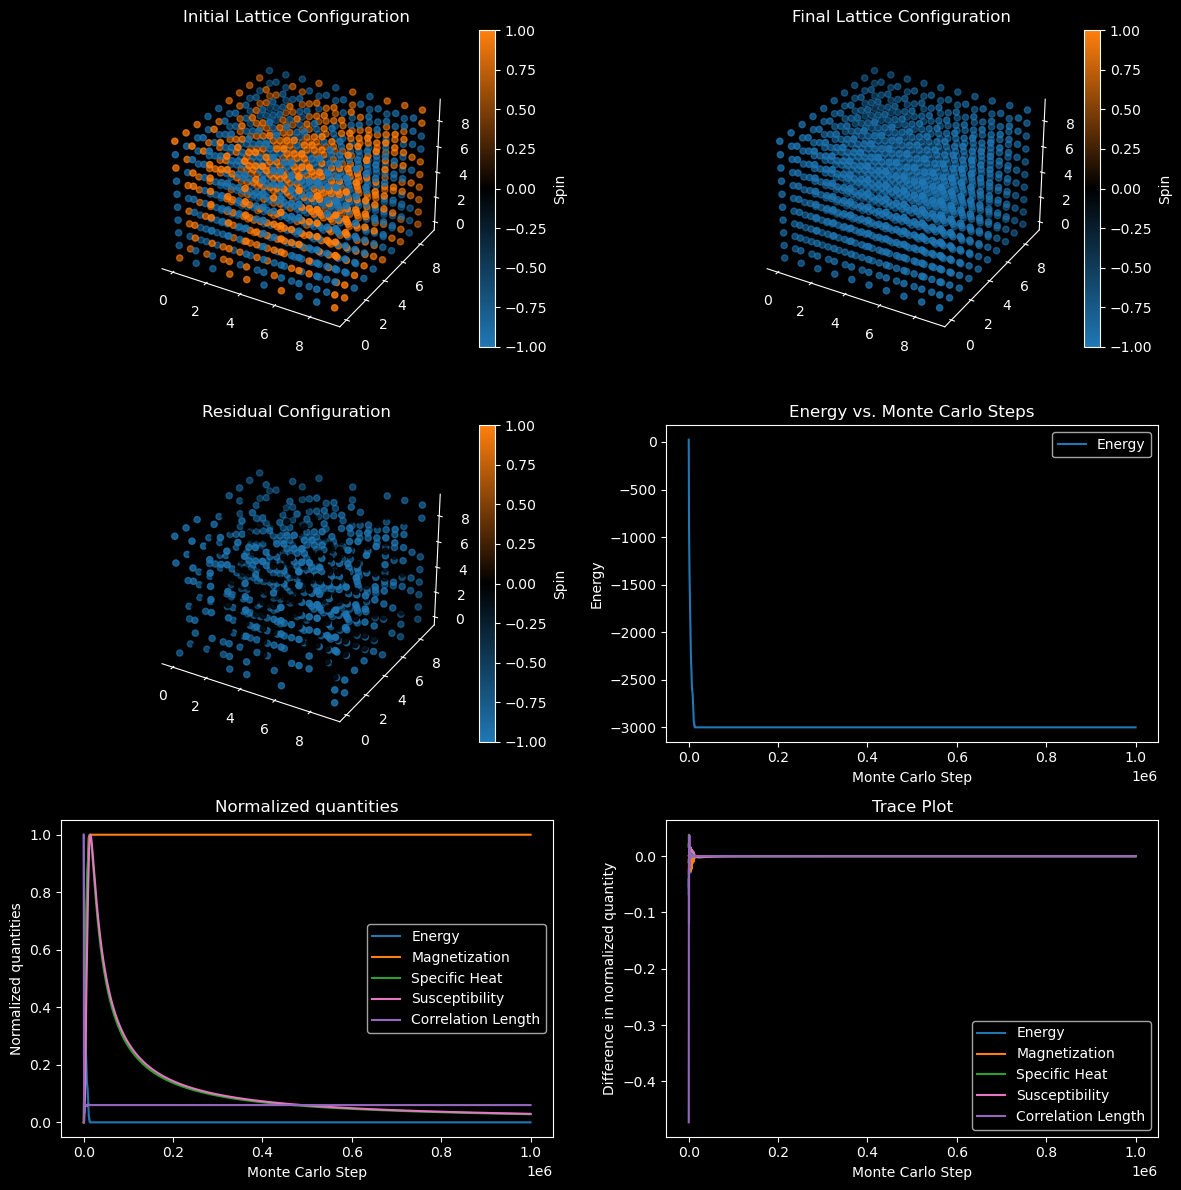

[1139.814492266133, 566.5013144479981, 370.2595395789376, 282.8100904754727, 207.02054732960107, 179.96950086975556, 71.62999079334196, -72.77859175965452, -53.37520876448734, -42.187582430786385, -21.233638360630327, -18.121266729837295, -17.024779903412004, -31.76984232287562, -32.47938761245267, -29.172096594063415, 15.761973637987522, 12.954954620484623, 11.5110851327714, 10.25617447592957, 10.49365911145304, 9.158617594167405, -16.237319877919393, -16.237319877919393, -14.114808967187443, -7.009989429308702, -9.034464167611464, -8.262945425974259, -7.685835223195503, -7.404336581331997, -6.86564940331145, -8.787171515175068, -8.54618295738651, -8.054925032822295, -7.493173955003388, -7.326094813034796, -7.129694965753094, -6.8758755057877945, -6.644159432887964, -6.403267149490066, -6.318893612541693, -5.98640766393805, -5.89388432631271, -5.8055011597949635, -3.210990282897427, -0.13318794887242952, -2.788851224732736, -2.7955646774308196, -2.80113334045835, -2.8033585771979284, 

In [41]:
T = 10**(-5)
K = 1
h = 0
L = 10
steps_per_spin = 1000
steps = L**3*steps_per_spin

spins_initial = initial_spins(L)
copy_of_spins_initial = spins_initial.copy()
final_spins, quantities = monte_carlo(T, K, h, L, steps, spins_initial)

# Visualization
cmap = "PiYG"
fig = plt.figure(figsize=(12, 12))

ax0 = fig.add_subplot(3, 2, 1, projection='3d')
scatter_3D(copy_of_spins_initial, ax0, "Initial Lattice Configuration")

ax1 = plt.subplot(3, 2, 2, projection='3d')
scatter_3D(final_spins, ax1, "Final Lattice Configuration")

ax2 = plt.subplot(3, 2, 3, projection='3d')
scatter_3D(final_spins - copy_of_spins_initial, ax2, "Residual Configuration")

energies = quantities[0]
plt.subplot(3, 2, 4)
plt.title("Energy vs. Monte Carlo Steps")
plt.plot(range(0, len(energies) * 100, 100), energies, label="Energy", color='tab:blue')
plt.xlabel("Monte Carlo Step")
plt.ylabel("Energy")
plt.legend()

plt.subplot(3, 2, 5)
plt.title("Normalized quantities")
xs = np.linspace(0, steps, len(quantities[0]))
plt.plot(xs, normalize(np.array(quantities[0])/L**3), label="Energy", color='tab:blue')
plt.plot(xs, normalize(np.abs(quantities[1])/L**3), label="Magnetization", color='tab:orange')
plt.plot(xs, normalize(quantities[2]), label="Specific Heat", color='tab:green')
plt.plot(xs, normalize(quantities[3]), label="Susceptibility", color='tab:pink')
plt.plot(xs, normalize(quantities[4]), label="Correlation Length", color='tab:purple')  # TODO
plt.xlabel("Monte Carlo Step")
plt.ylabel("Normalized quantities")
plt.legend()

plt.subplot(3, 2, 6)
plt.title("Trace Plot")
plt.plot(xs[:-1], difference(normalize(quantities[0])), label="Energy", color='tab:blue')
plt.plot(xs[:-1], difference(normalize(quantities[1])), label="Magnetization", color='tab:orange')
plt.plot(xs[:-1], difference(normalize(quantities[2])), label="Specific Heat", color='tab:green')
plt.plot(xs[:-1], difference(normalize(quantities[3])), label="Susceptibility", color='tab:pink')
plt.plot(xs[:-1], difference(normalize(quantities[4])), label="Correlation Length", color='tab:purple')  # TODO
plt.xlabel("Monte Carlo Step")
plt.ylabel("Difference in normalized quantity")
plt.legend()

plt.tight_layout()
plt.show()
plt.close()

# print(quantities[4])

In [42]:
def plot_final_vs_t(temps, final_vals, axs, name, L, c='tab:cyan'):
    axs.scatter(temps, final_vals, label=str(L), color=c)
    axs.axvline(x=4.5108, color='tab:pink')
    axs.set_xlabel("Temp")
    axs.set_ylabel(name)
    axs.legend()
    return axs

  0%|                                                              | 0/25 [00:00<?, ?it/s]/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_1707/1831189862.py:57: RuntimeWarning: divide by zero encountered in log
  xi = -r/np.log(diff)
 60%|███████████████████████████████▊                     | 15/25 [13:48<08:34, 51.46s/it]/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_1707/1831189862.py:57: RuntimeWarning: invalid value encountered in scalar divide
  xi = -r/np.log(diff)
/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_1707/1831189862.py:57: RuntimeWarning: divide by zero encountered in scalar divide
  xi = -r/np.log(diff)
100%|█████████████████████████████████████████████████████| 25/25 [22:16<00:00, 53.46s/it]


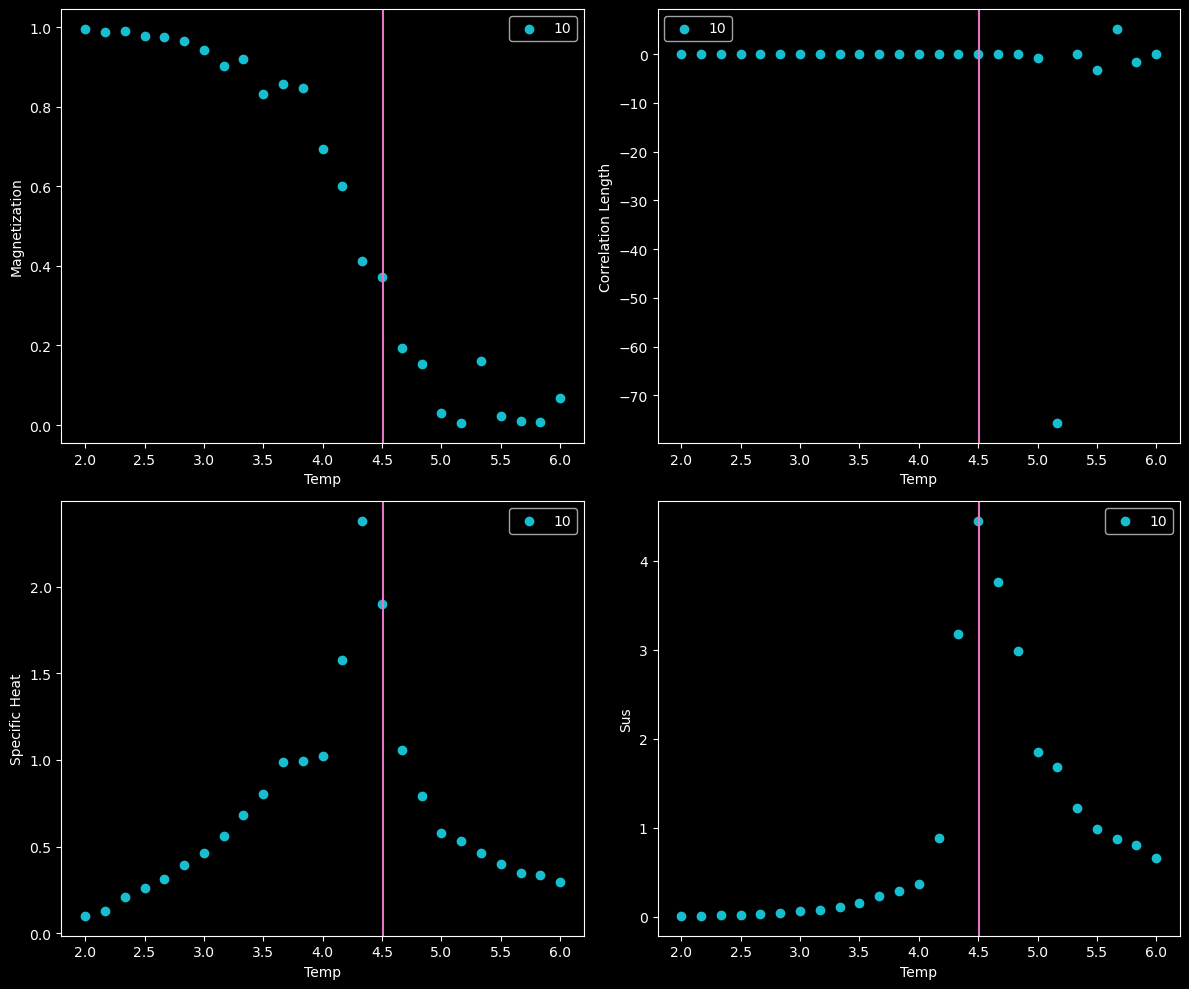

In [44]:
spins_aligned = aligned_spins(L)
temps = np.linspace(2, 6, 25)
final_Es = []
final_Ms = []
final_Cs = []
final_chis = []
final_xis = []

# turn off external magnetic field
K = 1
h = 0
L = 10
# steps = 10000

for T in tqdm(temps):
    aligned_spins_initial = spins_aligned.copy()
    _, quantities = monte_carlo(T, K, h, L, steps, aligned_spins_initial)
    final_Es.append(quantities[0][-1])
    final_Ms.append(quantities[1][-1])
    final_Cs.append(quantities[2][-1])
    final_chis.append(quantities[3][-1])
    final_xis.append(quantities[4][-1])

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# ax[0, 0] = plot_final_vs_t(temps, np.array(final_Es)/L**3, ax[0, 0], "Energy", L)
ax[0, 0] = plot_final_vs_t(temps, np.abs(final_Ms)/L**3, ax[0, 0], "Magnetization", L)
ax[0, 1] = plot_final_vs_t(temps, np.array(final_xis)/L**3, ax[0, 1], "Correlation Length", L)
ax[1, 0] = plot_final_vs_t(temps, final_Cs, ax[1, 0], "Specific Heat", L)
ax[1, 1] = plot_final_vs_t(temps, np.array(final_chis)/L**3, ax[1, 1], "Sus", L)

plt.tight_layout()
plt.show()
plt.close()

  0%|                                                              | 0/25 [00:00<?, ?it/s]/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_1707/1831189862.py:57: RuntimeWarning: divide by zero encountered in log
  xi = -r/np.log(diff)
 48%|█████████████████████████▍                           | 12/25 [11:22<12:30, 57.75s/it]/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_1707/1831189862.py:57: RuntimeWarning: invalid value encountered in scalar divide
  xi = -r/np.log(diff)
/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_1707/1831189862.py:57: RuntimeWarning: divide by zero encountered in scalar divide
  xi = -r/np.log(diff)
  4%|█▉                                               | 1/25 [25:32<10:13:05, 1532.74s/it]


KeyboardInterrupt: 

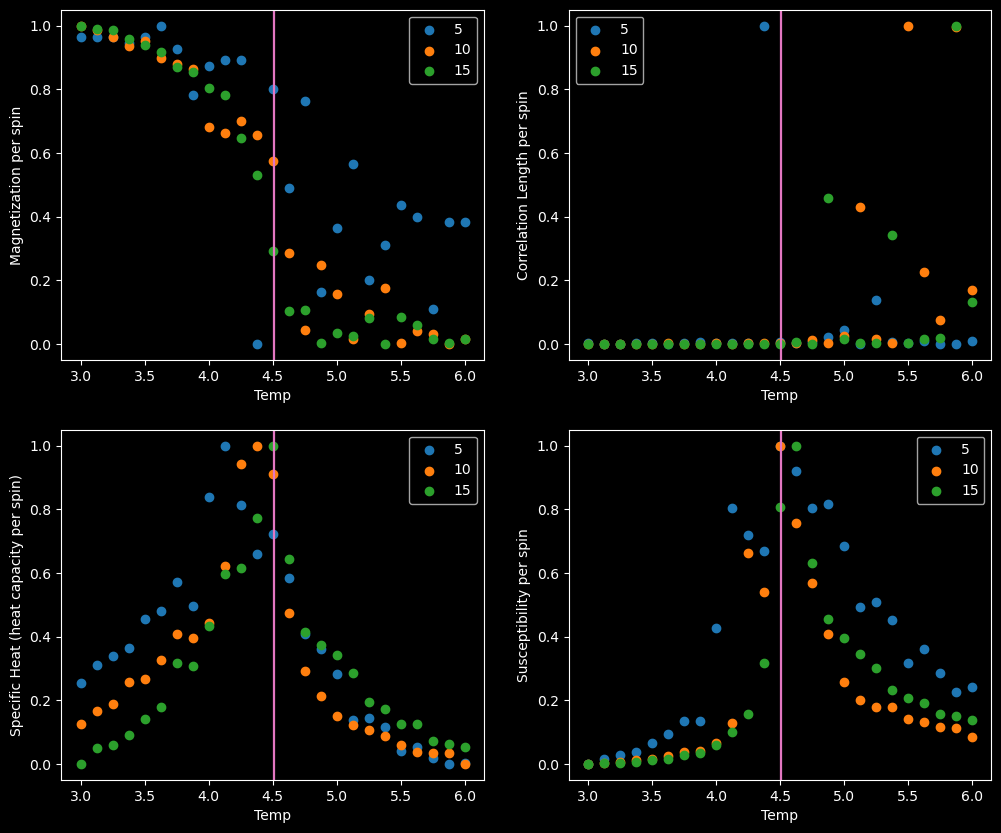

In [45]:
max_Cs = []
max_suss = []
T_cs = []
max_Ms = []
max_xis = []
steps_per_spin = 1000

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Ls = [15, 11, 9, 7, 5]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:pink', 'tab:purple', 'tab:cyan']
Ls = [5, 10, 15, 20, 25]
for L in Ls:
    # turn off external magnetic field
    h = 0
    steps = steps_per_spin*L**3

    # set color:
    c = colors[int(L/5 - 1)]

    spins_aligned = aligned_spins(L)
    temps = np.linspace(3, 6, 25)
    final_Es = []
    final_Ms = []
    final_Cs = []
    final_chis = []
    final_xis = []

    for T in tqdm(temps):
    # T = 4.5108
        aligned_spins_initial = spins_aligned.copy()
        _, quantities = monte_carlo(T, K, h, L, steps, aligned_spins_initial)
        final_Es.append(quantities[0][-1])
        final_Ms.append(quantities[1][-1])
        final_Cs.append(quantities[2][-1])
        final_chis.append(quantities[3][-1])
        final_xis.append(quantities[4][-1])
    
    max_Cs.append(np.max(final_Cs))
    T_c_i = np.argmax(final_Cs)
    T_cs.append(temps[T_c_i])
    
    max_suss.append(final_chis[T_c_i])
    max_Ms.append(final_Ms[T_c_i])
    max_xis.append(final_xis[T_c_i])
        
    # ax[0, 0] = plot_final_vs_t(temps, normalize(np.array(final_Es)/L**3), ax[0, 0], "Energy per spin", L)
    ax[0, 0] = plot_final_vs_t(temps, normalize(np.abs(final_Ms)/L**3), ax[0, 0], "Magnetization per spin", L, c)
    ax[0, 1] = plot_final_vs_t(temps, normalize(np.abs(final_xis)/L**3), ax[0, 1], "Correlation Length per spin", L, c)
    ax[1, 0] = plot_final_vs_t(temps, normalize(final_Cs), ax[1, 0], "Specific Heat (heat capacity per spin)", L, c)
    ax[1, 1] = plot_final_vs_t(temps, normalize(np.array(final_chis)/L**3), ax[1, 1], "Susceptibility per spin", L, c)

print(T_cs)

plt.tight_layout()
plt.show()
plt.close()

In [49]:
max_Cs = []
max_suss = []
max_Ms = []
max_xis = []
steps_per_spin = 1000

Ls = [25, 20, 15, 10, 5]
for L in Ls:
    h = 0
    steps = steps_per_spin*L**3
    T = 4.5108
    spins_aligned = aligned_spins(L)
    aligned_spins_initial = spins_aligned.copy()
    _, quantities = monte_carlo(T, K, h, L, steps, aligned_spins_initial)
    
    max_Ms.append(quantities[1][-1])
    max_Cs.append(quantities[2][-1])
    max_suss.append(quantities[3][-1])
    max_xis.append(quantities[4][-1])


  0%|                                                        | 0/15625000 [00:00<?, ?it/s]/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_1707/1831189862.py:57: RuntimeWarning: divide by zero encountered in log
  xi = -r/np.log(diff)
 94%|██████████████████████████████████████▋  | 7552001/8000000 [34:27<02:28, 3022.39it/s]/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_1707/1831189862.py:57: RuntimeWarning: invalid value encountered in scalar divide
  xi = -r/np.log(diff)
/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_1707/1831189862.py:57: RuntimeWarning: divide by zero encountered in scalar divide
  xi = -r/np.log(diff)
100%|██████████████████████████████████████████| 125000/125000 [00:04<00:00, 28984.15it/s]


/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_1707/1473211128.py:16: RuntimeWarning: invalid value encountered in log
  y4 = np.log(max_xis)


[0.296, 0.04225, 0.37066666666666664, 0.504, 0.472]


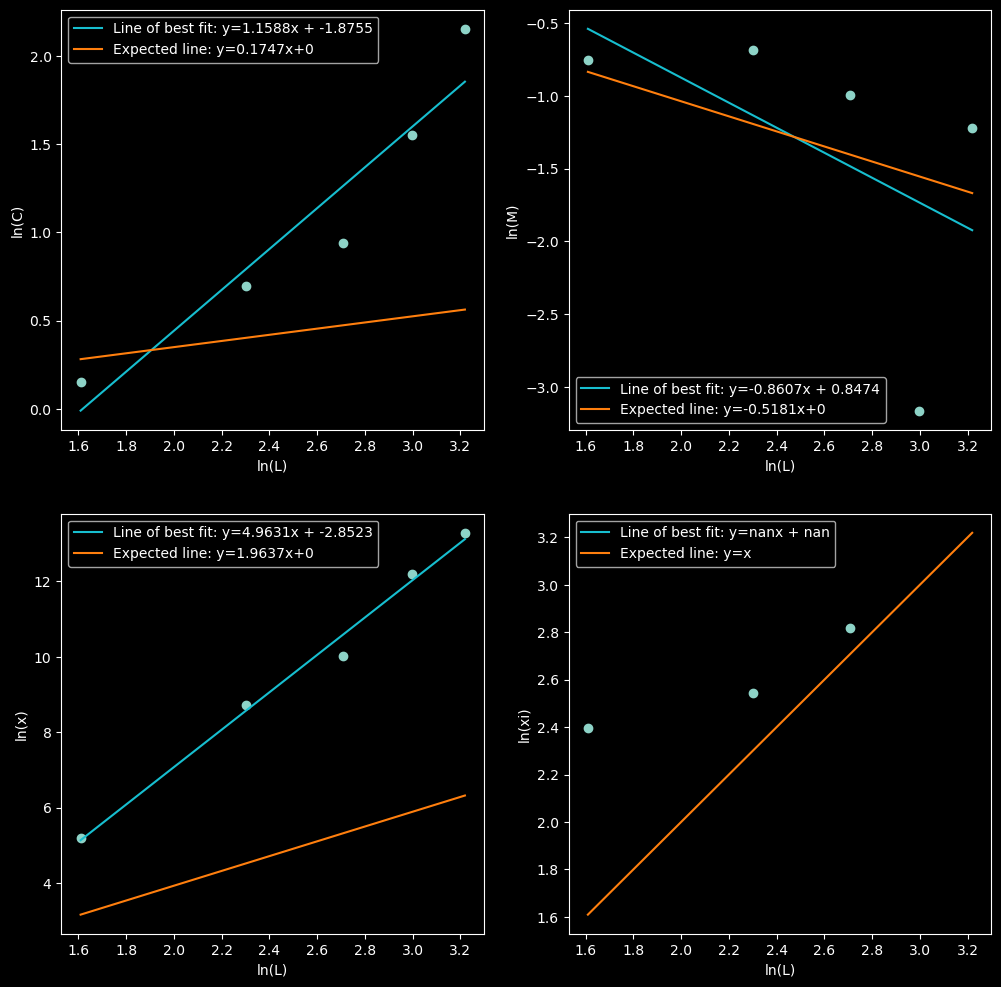

In [62]:
expected_nu = 0.62997097
expected_alpha = 0.11008708
expected_beta = 0.32641871
expected_gamma = 1.23707551
expected_delta = 4.78984254
expected_eta = 0.036297612
expected_omega = 0.82966

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
# I messed up computing the average M values but I didn't have time to re-run so I just fixed them by hand here
max_Ms = [4625.0/(25**3), 338.0/(20**3), 1251.0/(15**3), 504.0/(10**3), 59.0/(5**3)]

x = np.log(Ls)
y1 = np.log(max_Cs)
y2 = np.log(max_suss)
y3 = np.log(max_Ms)
y4 = np.log(max_xis)
print(max_Ms)

coeffs1 = np.polyfit(x, y1, 1)
ax[0, 0].scatter(x, y1)
ax[0, 0].plot(x, coeffs1[0]*x + coeffs1[1], label=f"Line of best fit: y={round(coeffs1[0], 4)}x + {round(coeffs1[1], 4)}", color='tab:cyan')
ax[0, 0].plot(x, (expected_alpha/expected_nu)*x, label=f"Expected line: y={round((expected_alpha/expected_nu), 4)}x+0", color='tab:orange')
ax[0, 0].legend()
ax[0,0].set_xlabel("ln(L)")
ax[0,0].set_ylabel("ln(C)")


coeffs2 = np.polyfit(x, y2, 1)
ax[1, 0].scatter(x, y2)
ax[1, 0].plot(x, coeffs2[0]*x + coeffs2[1], label=f"Line of best fit: y={round(coeffs2[0], 4)}x + {round(coeffs2[1], 4)}", color='tab:cyan')
ax[1, 0].plot(x, (expected_gamma/expected_nu)*x, label=f"Expected line: y={round((expected_gamma/expected_nu), 4)}x+0", color='tab:orange')
ax[1, 0].legend()
ax[1,0].set_xlabel("ln(L)")
ax[1,0].set_ylabel("ln(x)")

coeffs3 = np.polyfit(x, y3, 1)
ax[0, 1].scatter(x, y3)
ax[0, 1].plot(x, coeffs3[0]*x + coeffs3[1], label=f"Line of best fit: y={round(coeffs3[0], 4)}x + {round(coeffs3[1], 4)}", color='tab:cyan')
ax[0, 1].plot(x, (-expected_beta/expected_nu)*x, label=f"Expected line: y={round((-expected_beta/expected_nu), 4)}x+0", color='tab:orange')
ax[0, 1].legend()
ax[0, 1].set_xlabel("ln(L)")
ax[0, 1].set_ylabel("ln(M)")

# coeffs4 = np.polyfit(x_adjusted, y4_adjusted, 1)
# ax[1, 1].scatter(x_adjusted, y4_adjusted)
# ax[1, 1].plot(x_adjusted, coeffs4[0]*x_adjusted + coeffs4[1], label=f"Line of best fit: y={round(coeffs4[0], 4)}x + {round(coeffs4[1], 4)}", color='tab:cyan')
# ax[1, 1].plot(x_adjusted, x_adjusted, label=f"Expected line: y=x", color='tab:orange')
# ax[1, 1].legend()
# ax[1, 1].set_xlabel("ln(L)")
# ax[1, 1].set_ylabel("ln(xi)")
coeffs4 = np.polyfit(x, y4, 1)
ax[1, 1].scatter(x, y4)
ax[1, 1].plot(x, coeffs4[0]*x + coeffs4[1], label=f"Line of best fit: y={round(coeffs4[0], 4)}x + {round(coeffs4[1], 4)}", color='tab:cyan')
ax[1, 1].plot(x, x, label=f"Expected line: y=x", color='tab:orange')
ax[1, 1].legend()
ax[1, 1].set_xlabel("ln(L)")
ax[1, 1].set_ylabel("ln(xi)")

plt.show()
plt.close()


[-19.474470100248325, -1160.4188729624543, 16.71575359898445, 12.723108429705476, 10.995534652996703]
